In [5]:
import os
import numpy as np
import pandas as pd
from natsort import natsorted
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import sys

ParserError: Error tokenizing data. C error: Expected 1 fields in line 3, saw 2


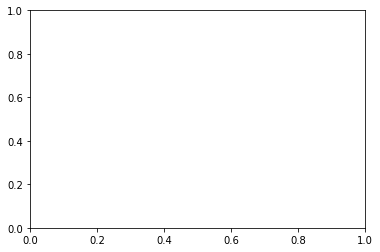

In [7]:
dir = 'C:\\Users\\wj2002\\Dropbox (Heriot-Watt University Team)\\2021_HWU\Exp data-2021\\20221123_0_1%_PrYVO4_absorption_whitelight'
folder = '2.7K'

path=dir + '\\' + folder + '\\'
file_list = os.listdir(path)
list_csv=natsorted([i for i in file_list if i.endswith('.csv')])
file_size=np.shape(list_csv)
data_file_len=file_size[0]

fig,ax = plt.subplots()
for index, file in enumerate(list_csv):
    data=pd.read_csv(os.path.join(path,file))
    data=data.to_numpy()
    ax.plot(data[:,0],data[:,1])